In [20]:
#Import
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from joblib import load
import numpy as np
import matplotlib.pyplot as plt



# Load data

In [ ]:

def read_data():
    df = pd.read_json('./0.5percent_threshold_20100101-20191231.json')
    return df

df = read_data()
X = df.text
y = df.alpha_label

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.2, stratify=y)

tfidf = load('./tfidf_05dataset.joblib')
X_transformed = tfidf.transform(X)

logreg = load('./logreg_05dataset.joblib')
X_test_transformed = tfidf.transform(X_test)

logreg = load('./logreg_05dataset.joblib')
y_pred_proba = logreg.predict_proba(X_test_transformed)

probabilities = pd.DataFrame(y_pred_proba, columns=['Down','Stable','Up'])

# Calculate mean precision of 'Up' and 'Down'

In [25]:
mean_precisions = []
actions = []
thresholds = [percent/100 for percent in range(0,101,1)]
    
for threshold in thresholds:
    probabilities = predict(threshold, probabilities)
    y_pred = probabilities.predicted

    precision_down = confusion_matrix(y_pred, y_test)[0][0]/np.sum(confusion_matrix(y_pred, y_test)[0])
    precision_up = confusion_matrix(y_pred, y_test)[2][2]/np.sum(confusion_matrix(y_pred, y_test)[2])
    mean_precision = (precision_up+precision_down)/2
    mean_precisions.append(mean_precision)
    action = (np.sum(confusion_matrix(y_pred, y_test)[0])+np.sum(confusion_matrix(y_pred, y_test)[2]))/np.sum(confusion_matrix(y_pred, y_test))
    actions.append(action)
    
output = pd.DataFrame({'threshold':thresholds, 'actions':actions, 'mean_precision':mean_precisions})
output.to_csv('mean_precisions.csv', index=False, header=True)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in long_scalars
  if __name__ == '__main__':
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in long_scalars
  # Remove the CWD from sys.path while we load stuff.


# Visualize the probability threshold

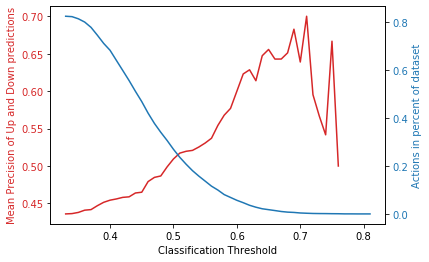

In [45]:
#Visualize already generated probability thresholds
mean_precisions_data=pd.read_csv('mean_precisions.csv')
mean_precisions_data = mean_precisions_data[33:82]
thresholds = mean_precisions_data.threshold
mean_precisions=mean_precisions_data.mean_precision
actions = mean_precisions_data.actions

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_ylabel('Mean Precision of Up and Down predictions', color=color)
ax1.plot(thresholds, mean_precisions, color=color, label='Actions in percent of dataset')
ax1.set_xlabel('Classification Threshold')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()

color = 'tab:blue'
ax2.set_ylabel('Actions in percent of dataset', color=color)
ax2.plot(thresholds, actions, color=color)#, label='Actions in percent of dataset')
ax2.tick_params(axis='y', labelcolor=color)

plt.savefig('./mean_precisions')
plt.show()

In [22]:
#Test new thresholds

def predict(threshold, probabilities):
    for row in range(len(probabilities)):
        if probabilities.iloc[row].Stable > probabilities.iloc[row].Down and probabilities.iloc[row].Stable > probabilities.iloc[row].Up:
            probabilities.loc[row, 'predicted'] = 'Stable'
        
        elif probabilities.iloc[row].Down>threshold and probabilities.iloc[row].Down>probabilities.iloc[row].Up:
            probabilities.loc[row, 'predicted'] = 'Down'
            
        elif probabilities.iloc[row].Up>threshold and probabilities.iloc[row].Up>probabilities.iloc[row].Down:
            probabilities.loc[row, 'predicted'] = 'Up'
            
        else:
            probabilities.loc[row, 'predicted'] = 'Stable'
    
    return probabilities


threshold=0.45
probabilities = predict(threshold, probabilities)
y_pred = probabilities.predicted

print(confusion_matrix(y_pred = y_pred, y_true = y_test))
print(classification_report(y_true = y_test, y_pred = y_pred))
print('Accuracy:', accuracy_score(y_test, y_pred))

precision_down = confusion_matrix(y_pred, y_test)[0][0]/np.sum(confusion_matrix(y_pred, y_test)[0])
precision_up = confusion_matrix(y_pred, y_test)[2][2]/np.sum(confusion_matrix(y_pred, y_test)[2])
mean_precision = (precision_up+precision_down)/2

print('Mean Precision:', mean_precision)

[[551 950 487]
 [225 911 240]
 [392 998 615]]
              precision    recall  f1-score   support

        Down       0.47      0.28      0.35      1988
      Stable       0.32      0.66      0.43      1376
          Up       0.46      0.31      0.37      2005

    accuracy                           0.39      5369
   macro avg       0.42      0.42      0.38      5369
weighted avg       0.43      0.39      0.38      5369

Accuracy: 0.38685043769789534
Mean Precision: 0.4650089061511137


In [93]:
labels = pd.DataFrame()
count = pd.DataFrame()
labels['Labels'] = probabilities.predicted
count = labels.apply(pd.value_counts)
counter = count.loc['Up', 'Labels'] + count.loc['Down', 'Labels']
print(counter)
percent = counter/len(labels.index)
print(percent)
estimation = counter * percent
print(estimation)

631
0.11752654125535482
74.15924753212889
